In [1]:
import numpy as np
import dask
import xarray as xr
import matplotlib.pyplot as plt
import os
from os.path import isfile
import datetime as dt
from salishsea_tools import evaltools as et, viz_tools
import glob
import dask
import netCDF4 as nc
from dask.distributed import Client, progress
import dask.array as da
%matplotlib inline

In [2]:
meshPath='/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc'
maskName='tmask'

In [3]:
j0=230;j1=470;i0=0;i1=200;
#ct=240;cz=40;cy=50;cx=200;

In [4]:
client = dask.distributed.Client(
    n_workers=2, threads_per_worker=2, processes=True)
client

Client Scheduler: tcp://127.0.0.1:41451 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 16.77 GB


In [6]:
with nc.Dataset("/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc") as mesh:
    tmask=np.copy(mesh.variables['tmask'][:,:,j0:j1,i0:i1])
    e3t0=np.copy(mesh.variables['e3t_0'][:,:,j0:j1,i0:i1])

In [7]:
flistmuZ=et.index_model_files(dt.datetime(2015,6,1),dt.datetime(2015,9,1),
                             '/data/eolson/results/MEOPAR/SS36runs/CedarRuns/testmuZ/',
                             'long',10,'ptrc_T',1)

first file starts on  2015-05-31 00:00:00


In [8]:
flistHC=et.index_model_files(flistmuZ['t_0'][0],flistmuZ['t_n'][len(flistmuZ)-1]-dt.timedelta(days=1),
                             '/results/SalishSea/hindcast.201905/',
                             'nowcast',1,'ptrc_T',1)

In [9]:
chunks = {"time_counter": 3, "deptht": 40*3, "y": 898*3, "x": 398*3}

In [10]:
t0=dt.datetime.now()
dataHC=xr.open_mfdataset(flistHC['paths'],data_vars=('diatoms','microzooplankton'),chunks=chunks,
            drop_variables=('nitrate','ammonium','silicon','flagellates','ciliates','dissolved_organic_nitrogen',
                            'particulate_organic_nitrogen','biogenic_silicon','mesozooplankton'),parallel=True,`combine='by_coords')
diatoms = dataHC.diatoms.isel(y=slice(j0, j1), x=slice(i0, i1))
diatoms_int = (diatoms * tmask * e3t0).sum(axis=1).mean(axis=0)
uZ = dataHC.microzooplankton.isel(y=slice(j0, j1), x=slice(i0, i1))
uZ_int = (uZ * tmask * e3t0).sum(axis=1).mean(axis=0)
t1=dt.datetime.now()
print(t1-t0)

/home/eolson/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel/__main__.py:4: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

/home/eolson/.local/lib/python3.7/site-packages/xarray/backends/api.py:933: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


0:01:31.213300


In [11]:
dataHC

<xarray.Dataset>
Dimensions:               (axis_nbounds: 2, deptht: 40, nvertex: 4, time_counter: 2400, x: 398, y: 898)
Coordinates:
    nav_lat               (y, x) float32 dask.array<chunksize=(898, 398), meta=np.ndarray>
    nav_lon               (y, x) float32 dask.array<chunksize=(898, 398), meta=np.ndarray>
  * deptht                (deptht) float32 0.5000003 1.5000031 ... 441.4661
    time_centered         (time_counter) datetime64[ns] dask.array<chunksize=(3,), meta=np.ndarray>
  * time_counter          (time_counter) datetime64[ns] 2015-05-31T00:30:00 ... 2015-09-07T23:30:00
Dimensions without coordinates: axis_nbounds, nvertex, x, y
Data variables:
    bounds_lon            (y, x, nvertex) float32 dask.array<chunksize=(898, 398, 4), meta=np.ndarray>
    deptht_bounds         (deptht, axis_nbounds) float32 dask.array<chunksize=(40, 2), meta=np.ndarray>
    bounds_lat            (y, x, nvertex) float32 dask.array<chunksize=(898, 398, 4), meta=np.ndarray>
    area                  (y, x) float32 dask.array<chunksize=(898, 398), meta=np.ndarray>
    time_centered_bounds  (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(3, 2), meta=np.ndarray>
    time_counter_bounds   (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(3, 2), meta=np.ndarray>
    diatoms               (time_counter, deptht, y, x) float32 dask.array<chunksize=(3, 40, 898, 398), meta=np.ndarray>
    microzooplankton      (time_counter, deptht, y, x) float32 dask.array<chunksize=(3, 40, 898, 398), meta=np.ndarray>
Attributes:
    name:         SalishSea_1h_20150526_20150531
    description:  biogeochemical variables
    title:        biogeochemical variables
    Conventions:  CF-1.6
    timeStamp:    2019-Sep-25 01:38:45 GMT
    uuid:         7abb4fe2-2cf5-475e-b3c2-b5200adfd953

In [12]:
t0=dt.datetime.now()
datamuZ=xr.open_mfdataset(flistmuZ['paths'],data_vars=('diatoms','microzooplankton'),chunks=chunks,
            drop_variables=('nitrate','ammonium','silicon','flagellates','ciliates','dissolved_organic_nitrogen',
                            'particulate_organic_nitrogen','biogenic_silicon','mesozooplankton'),parallel=True)
datamuZ=datamuZ.rename({'time_counter':'t','deptht':'z'})
diatoms = datamuZ.diatoms.isel(y=slice(j0, j1), x=slice(i0, i1))
diatoms_int = (diatoms * tmask * e3t0).sum(axis=1).mean(axis=0)
uZ = datamuZ.microzooplankton.isel(y=slice(j0, j1), x=slice(i0, i1))
uZ_int = (uZ * tmask * e3t0).sum(axis=1).mean(axis=0)
t1=dt.datetime.now()
print(t1-t0)

/home/eolson/anaconda3/envs/py37/lib/python3.7/site-packages/ipykernel/__main__.py:4: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

/home/eolson/.local/lib/python3.7/site-packages/xarray/backends/api.py:933: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


0:00:08.125841


In [13]:
diatoms

<xarray.DataArray 'diatoms' (t: 2400, z: 40, y: 240, x: 200)>
dask.array<getitem, shape=(2400, 40, 240, 200), dtype=float32, chunksize=(3, 40, 240, 200), chunktype=numpy.ndarray>
Coordinates:
    nav_lat        (y, x) float32 dask.array<chunksize=(240, 200), meta=np.ndarray>
    nav_lon        (y, x) float32 dask.array<chunksize=(240, 200), meta=np.ndarray>
  * z              (z) float32 0.5000003 1.5000031 ... 414.5341 441.4661
    time_centered  (t) datetime64[ns] dask.array<chunksize=(3,), meta=np.ndarray>
  * t              (t) datetime64[ns] 2015-05-31T00:30:00 ... 2015-09-07T23:30:00
Dimensions without coordinates: y, x
Attributes:
    standard_name:       mole_concentration_of_diatoms_expressed_as_nitrogen_...
    long_name:           Diatoms Concentration
    units:               mmol m-3
    online_operation:    average
    interval_operation:  40 s
    interval_write:      1 h
    cell_methods:        time: mean (interval: 40 s)
    cell_measures:       area: area

NameError: name 'diatomsmuZInt' is not defined

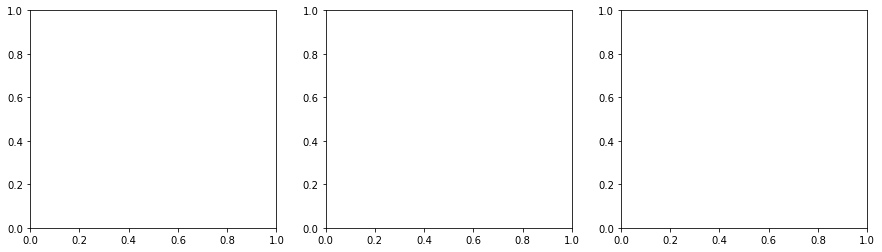

In [14]:
t0=dt.datetime.now()
fig,ax=plt.subplots(1,3,figsize=(15,4))
m0=ax[0].pcolormesh(diatomsmuZInt)
plt.colorbar(m0,ax=ax[0])
ax[0].set_title('muZ Diatoms')
m1=ax[1].pcolormesh(diatomsHCInt)
plt.colorbar(m1,ax=ax[1])
ax[1].set_title('HC Diatoms')
m2=ax[2].pcolormesh(diatomsmuZInt-diatomsHCInt)
plt.colorbar(m2,ax=ax[2])
ax[2].set_title('Diff')
t1=dt.datetime.now()
print(t1-t0)

In [ ]:
client.close()